In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils import class_weight, resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import recall_score, precision_score

data = pd.read_csv("../data/data_imputed.csv")
#drop values where other_cancer is equal to don't know
data = data[data.other_cancer != "Don't know / Not Sure / Refused / Missing"]

#get index of categorical features
cat_cols = data.select_dtypes(include='object').columns
cat_cols_idx = [col in cat_cols for col in data.columns]

label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
del column, label_encoders, le

target = 'other_cancer'
X = data.drop(target, axis=1)  # Features (all columns except the target)
y = data[target]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
def decision_tree(X_train, X_test, y_train, y_test, class_weight=None, return_clf = False):
    if class_weight is None:
        clf = DecisionTreeClassifier()
    else:
        clf = DecisionTreeClassifier(class_weight=class_weight)
    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    model_results(y_pred, y_test, y_pred_proba)

    if return_clf:
        return clf
    

def random_forest(X_train, X_test, y_train, y_test, class_weight=None, return_clf = False):
    if class_weight is None:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)

    # Train the model
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Make predictions
    y_pred = clf.predict(X_test)

    model_results(y_pred, y_test, y_pred_proba)

    if return_clf:
        return clf
        
def model_results(y_pred, y_test, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    #calculate f1 score
    f1 = f1_score(y_test, y_pred, average='macro')
    print("F1 score:", f1)

    report = classification_report(y_test, y_pred)
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print('ROC AUC score:', roc_auc)

    sensitivity = recall_score(y_test, y_pred)
    print('Sensitivity:', sensitivity)  

    precision = precision_score(y_test, y_pred)
    print('Precision:', precision)

def feature_importance(clf):
    importances = clf.feature_importances_

    # Print the name and importance of each feature 
    for feature_name, importance in zip(X.columns, importances):
        print(f"{feature_name}: {importance}")
    #sort features by importance
    sorted(zip(importances, X.columns), reverse=True)

    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    names = [X.columns[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance")

    # Add bars
    plt.bar(range(X.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(X.shape[1]), names, rotation=90)

    # Show plot
    plt.show()
        

In [3]:
print("Decision Tree without class weighting")
decision_tree(X_train, X_test, y_train, y_test)

print("\nRandom Forest without class weighting")
random_forest(X_train, X_test, y_train, y_test)

Decision Tree without class weighting
Accuracy: 0.80
F1 score: 0.5618265567951638
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     61847
           1       0.22      0.25      0.24      8432

    accuracy                           0.80     70279
   macro avg       0.56      0.57      0.56     70279
weighted avg       0.82      0.80      0.81     70279

Confusion Matrix:
[[54449  7398]
 [ 6319  2113]]
ROC AUC score: 0.5654876063517705
Sensitivity: 0.25059297912713474
Precision: 0.22216381032488697

Random Forest without class weighting
Accuracy: 0.88
F1 score: 0.5033031162687468
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     61847
           1       0.50      0.04      0.07      8432

    accuracy                           0.88     70279
   macro avg       0.69      0.52      0.50     70279
weighted avg       0.84      0.88      0.83     70279

Confusion Matrix:
[[61525   322]
 

In [4]:
# from sklearn.tree import export_graphviz
# import graphviz
# import pydotplus

# dot_data = export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_png('decision_tree.png')

In [5]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print("Decision Tree with class weighting")
decision_tree(X_train, X_test, y_train, y_test, class_weights_dict)

print("\nRandom Forest without class weighting")
random_forest(X_train, X_test, y_train, y_test, class_weights_dict)

Decision Tree with class weighting
Accuracy: 0.81
F1 score: 0.5597369869802921
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     61847
           1       0.23      0.22      0.22      8432

    accuracy                           0.81     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.81      0.81     70279

Confusion Matrix:
[[55385  6462]
 [ 6548  1884]]
ROC AUC score: 0.559475444990053
Sensitivity: 0.22343453510436434
Precision: 0.22573687994248742

Random Forest without class weighting
Accuracy: 0.88
F1 score: 0.49479134663560026
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     61847
           1       0.47      0.03      0.05      8432

    accuracy                           0.88     70279
   macro avg       0.68      0.51      0.49     70279
weighted avg       0.83      0.88      0.83     70279

Confusion Matrix:
[[61575   272]
 [ 8

In [6]:
# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Decision Tree with Undersampling")
decision_tree(X_resampled, X_test, y_resampled, y_test)

print("\nRandom Forest with Undersampling")
random_forest(X_resampled, X_test, y_resampled, y_test)

Decision Tree with Undersampling
Accuracy: 0.62
F1 score: 0.5116496476355418
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     61847
           1       0.18      0.61      0.28      8432

    accuracy                           0.62     70279
   macro avg       0.55      0.62      0.51     70279
weighted avg       0.83      0.62      0.69     70279

Confusion Matrix:
[[38484 23363]
 [ 3251  5181]]
ROC AUC score: 0.6183450947875317
Sensitivity: 0.614444971537002
Precision: 0.18150924887892378

Random Forest with Undersampling
Accuracy: 0.67
F1 score: 0.5658549349885693
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     61847
           1       0.23      0.76      0.35      8432

    accuracy                           0.67     70279
   macro avg       0.59      0.71      0.57     70279
weighted avg       0.87      0.67      0.73     70279

Confusion Matrix:
[[40593 21254]
 [ 2034  6398

In [7]:
# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Decision Tree with Oversampling")
decision_tree(X_resampled, X_test, y_resampled, y_test)

print("\nRandom Forest with Oversampling")
random_forest(X_resampled, X_test, y_resampled, y_test)

Decision Tree with Oversampling
Accuracy: 0.81
F1 score: 0.5568089466905847
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     61847
           1       0.22      0.22      0.22      8432

    accuracy                           0.81     70279
   macro avg       0.56      0.56      0.56     70279
weighted avg       0.81      0.81      0.81     70279

Confusion Matrix:
[[55207  6640]
 [ 6565  1867]]
ROC AUC score: 0.5570283454358462
Sensitivity: 0.22141840607210625
Precision: 0.219466321852592

Random Forest with Oversampling
Accuracy: 0.87
F1 score: 0.5557918892105246
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     61847
           1       0.40      0.12      0.18      8432

    accuracy                           0.87     70279
   macro avg       0.65      0.55      0.56     70279
weighted avg       0.83      0.87      0.84     70279

Confusion Matrix:
[[60395  1452]
 [ 7453   979]]

In [3]:
ratio = 2
majority_sample_size = int(len(data[data[target]==1]) * ratio)
# Downsample majority class to 50000 samples
majority_downsampled = resample(data[data[target]==0],
                                replace=False, # sample without replacement
                                n_samples= majority_sample_size, # number of samples to downsample to
                                random_state=42) # reproducible results

# Combine minority class and downsampled majority class
downsampled_data = pd.concat([majority_downsampled, data[data[target]==1]])

# Shuffle the data
downsampled_data = downsampled_data.sample(frac=1, random_state=42)

X = downsampled_data.drop(target, axis=1)  # Features (all columns except the target)
y = downsampled_data[target]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTENC(random_state=42, categorical_features = cat_cols_idx)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


Random Forest with SMOTENC
Accuracy: 0.75
F1 score: 0.6337399664303519
              precision    recall  f1-score   support

           0       0.86      0.82      0.84     33301
           1       0.40      0.47      0.43      8451

    accuracy                           0.75     41752
   macro avg       0.63      0.64      0.63     41752
weighted avg       0.76      0.75      0.76     41752

Confusion Matrix:
[[27314  5987]
 [ 4512  3939]]
ROC AUC score: 0.7549512963677003
Sensitivity: 0.46609868654597086
Precision: 0.3968365907717107
Feature Importances:
state: 0.092283446042328
health_insurance: 0.05114914380367617
personal_physician: 0.02263307586748981
doctor_visit_ability: 0.006206666434091245
last_visit: 0.02775605900040128
stroke: 0.006665208990125121
skin_cancer: 0.024359963977752266
copd: 0.009493226838047713
depression: 0.015099795943801862
kidney_disease: 0.008138504794140623
diabetes: 0.015755329170184663
employment: 0.03857689328194738
pneumonia_shot: 0.030786210481942

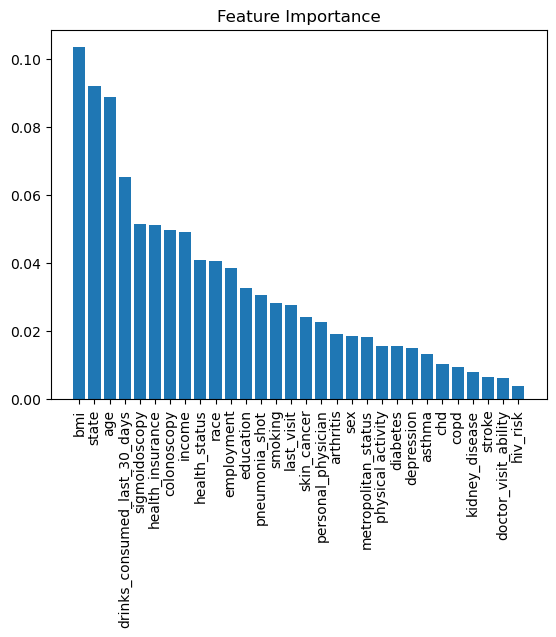

In [4]:
# print("Decision Tree with SMOTENC")
# clf = decision_tree(X_resampled, X_test, y_resampled, y_test, return_clf=True)
# print ("Feature Importances:")
# feature_importance(clf)

print("\nRandom Forest with SMOTENC")
clf = random_forest(X_resampled, X_test, y_resampled, y_test, return_clf=True)
print ("Feature Importances:")
feature_importance(clf)

In [10]:
#USE F1 MACRO INSTEAD OF ACCURACY
#RECALL
#ROC AND AOC
#more false positives than false negatives
#more sensitivisity than specificity instead of false positives/negatives


In [11]:
#consider converting numerical to categorical via bins
#random forest feature selection
#one hot encoding
#frequency encoding
#chi square
#try dividing data set by age
